In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

rating_df = pd.read_pickle("../../data/processed/rating_session.pkl")
longtail_df = pd.read_pickle("../../data/processed/longtail_indicator.pkl")

num_items = longtail_df["item_id"].max() + 1
rating_df

,user_id,date,item_id,rating,is_head
0,5,2015-03-27,"[1740, 2122, 5909, 7031, 10230, 10229]","[4.0, 5.0, 4.0, 5.0, 4.0, 5.0]","[0, 1, 1, 1, 1, 1]"
1,5,2016-02-24,"[6468, 7833, 7390, 5752, 15457, 26034]","[4.0, 4.0, 5.0, 4.0, 5.0, 5.0]","[0, 0, 0, 1, 1, 1]"
2,5,2016-02-24,"[7833, 7390, 5752, 15457, 26034, 10345]","[4.0, 5.0, 4.0, 5.0, 5.0, 5.0]","[0, 0, 1, 1, 1, 1]"
3,5,2016-02-24,"[7390, 5752, 15457, 26034, 10345, 18335]","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0]","[0, 1, 1, 1, 1, 1]"
4,9,2014-03-04,"[450, 451, 12373, 24897, 4126, 18538]","[5.0, 5.0, 2.0, 1.0, 5.0, 4.0]","[0, 0, 0, 1, 1, 1]"
...,...,...,...,...,...
16888,4993,2019-04-09,"[8394, 12235, 25185, 21281, 23606, 14018]","[3.0, 5.0, 5.0, 4.0, 5.0, 5.0]","[1, 1, 1, 1, 1, 1]"
16889,4993,2019-04-09,"[12235, 25185, 21281, 23606, 14018, 21547]","[5.0, 5.0, 4.0, 5.0, 5.0, 5.0]","[1, 1, 1, 1, 1, 1]"
16890,4993,2019-09-16,"[15370, 5784, 17893, 16523, 11703, 7327]","[5.0, 4.0, 5.0, 4.0, 4.0, 5.0]","[0, 0, 0, 0, 1, 1]"
16891,4993,2019-09-16,"[5784, 17893, 16523, 11703, 7327, 27390]","[4.0, 5.0, 4.0, 4.0, 5.0, 3.0]","[0, 0, 0, 1, 1, 1]"


In [2]:
num_items

27583

In [3]:
longtail_df = longtail_df.sort_values("item_id").reset_index(drop=True)
longtail_df

,item_id,is_head,item_len
0,0,0,3
1,1,0,2
2,2,0,4
3,3,0,7
4,4,0,3
...,...,...,...
27578,27578,0,5
27579,27579,0,3
27580,27580,1,15
27581,27581,1,15


In [4]:
num_items

27583

In [5]:
longtail_df["item_id"].max()

27582

In [6]:
head_mapping_lst = torch.tensor(longtail_df["is_head"].tolist()).long().cuda()
item_id_lst = torch.tensor(longtail_df["item_id"].tolist()).long()
print(head_mapping_lst[head_mapping_lst==0].shape, head_mapping_lst[head_mapping_lst==1].shape)

torch.Size([22067]) torch.Size([5516])


In [7]:
head_mapping_lst==0

tensor([ True,  True,  True,  ..., False, False,  True], device='cuda:0')

In [8]:
item_id_lst, head_mapping_lst

(tensor([    0,     1,     2,  ..., 27580, 27581, 27582]),
 tensor([0, 0, 0,  ..., 1, 1, 0], device='cuda:0'))

In [9]:
torch.unique(item_id_lst).shape

torch.Size([27583])

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

item_sequences = rating_df['item_id'].tolist()
user_ids = rating_df['user_id'].tolist()


class SessionDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        return torch.tensor(sequence[:-1]), torch.tensor(sequence[-1])
    
train_data, test_data = train_test_split(item_sequences, test_size=0.2, random_state=42)

# Hyperparameters
embedding_dim = 128
hidden_dim = 128
num_epochs = 1000
learning_rate = 5e-4
batch_size = 512
# 512 1e-4 0.4369
# 512 53-5 0.4404

train_loader = DataLoader(SessionDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SessionDataset(test_data), batch_size=batch_size, shuffle=False)

In [11]:
import torch.optim as optim
import sys
sys.path.append("../")
from model import TailNet



model = TailNet(num_items, embedding_dim, hidden_dim, head_mapping_lst).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
num_items, item_id_lst.max()

(27583, tensor(27582))

In [13]:
from sklearn.metrics import recall_score
from tqdm import tqdm
from copy import deepcopy
import warnings
warnings.filterwarnings('always')

model_parameters = deepcopy(model.state_dict())
K=20

recall_records, tail_records = [], []

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping_patience=5):
    global model_parameters
    best_val_recall = -float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, target in tqdm(train_loader):
            optimizer.zero_grad()
            is_head = head_mapping_lst[inputs.cuda()]
            outputs = model(inputs.cuda())
            loss = criterion(outputs, target.cuda())

            loss.backward()
            optimizer.step()
            total_loss += loss.detach().cpu().item()

        val_loss, val_recall, val_tail = evaluate(model, val_loader, criterion)
        recall_records.append(val_recall)
        tail_records.append(val_tail)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss:.4f},  Recall@20: {val_recall:.4f} Tail@20: {val_tail:.4f}')
        
        if val_recall > best_val_recall:
            best_val_recall = val_recall
            patience_counter = 0
            model_parameters = deepcopy(model.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0

    pred_lst, target_lst = [], []
    tail_lst = []
    
    with torch.no_grad():
        for idx, (inputs, target) in enumerate(tqdm(data_loader)):
            outputs = model(inputs.cuda())
            loss = criterion(outputs, target.cuda())
            total_loss += loss.detach().cpu().item()

            top_pred_idx = torch.argsort(outputs, dim=1, descending=True)[:, :K]
            tail_lst.append(head_mapping_lst[top_pred_idx])

            pred_lst.append(top_pred_idx.detach().cpu())
            target_lst.append(target.unsqueeze(dim=1).detach().cpu())
    
    pred_lst = torch.cat(pred_lst, dim=0)
    target_lst = torch.cat(target_lst, dim=0)
    tail_lst = torch.cat(tail_lst, dim=0)

    recall, tail = [], []
    for pred_idx, target_idx, is_tail in zip(pred_lst, target_lst, tail_lst):
        num_hit = target_idx[torch.isin(target_idx, pred_idx)].shape[0]
        recall.append(num_hit/target_idx.shape[0])
        # print(is_tail, is_tail.shape, is_tail[is_tail==0].shape[0], is_tail[is_tail==0].shape[0]/K)
        tail.append(is_tail[is_tail==0].shape[0]/K)

    avg_loss = total_loss / len(data_loader)
    avg_recall = np.mean(recall)    
    avg_tail = np.mean(tail)
    return avg_loss, avg_recall, avg_tail

train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs)


  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 49.01it/s]


Epoch [1/1000], Loss: 10.2250, Val Loss: 10.2250,  Recall@20: 0.0053 Tail@20: 0.1173


100%|██████████| 7/7 [00:00<00:00, 35.67it/s]


Epoch [2/1000], Loss: 10.2250, Val Loss: 10.2249,  Recall@20: 0.0299 Tail@20: 0.0877


100%|██████████| 7/7 [00:00<00:00, 50.93it/s]


Epoch [3/1000], Loss: 10.2215, Val Loss: 10.2207,  Recall@20: 0.0509 Tail@20: 0.1269


100%|██████████| 7/7 [00:00<00:00, 49.00it/s]


Epoch [4/1000], Loss: 10.2194, Val Loss: 10.2207,  Recall@20: 0.0521 Tail@20: 0.1334


100%|██████████| 7/7 [00:00<00:00, 51.73it/s]


Epoch [5/1000], Loss: 10.2186, Val Loss: 10.2207,  Recall@20: 0.0539 Tail@20: 0.1338


100%|██████████| 7/7 [00:00<00:00, 49.20it/s]


Epoch [6/1000], Loss: 10.2183, Val Loss: 10.2214,  Recall@20: 0.0633 Tail@20: 0.1353


100%|██████████| 7/7 [00:00<00:00, 30.31it/s]


Epoch [7/1000], Loss: 10.2162, Val Loss: 10.2214,  Recall@20: 0.0630 Tail@20: 0.1365


100%|██████████| 7/7 [00:00<00:00, 51.19it/s]


Epoch [8/1000], Loss: 10.2111, Val Loss: 10.2214,  Recall@20: 0.0604 Tail@20: 0.1367


100%|██████████| 7/7 [00:00<00:00, 45.92it/s]


Epoch [9/1000], Loss: 10.2044, Val Loss: 10.2214,  Recall@20: 0.0536 Tail@20: 0.1368


100%|██████████| 7/7 [00:00<00:00, 50.78it/s]


Epoch [10/1000], Loss: 10.1982, Val Loss: 10.2211,  Recall@20: 0.0512 Tail@20: 0.1370


100%|██████████| 7/7 [00:00<00:00, 51.79it/s]


Epoch [11/1000], Loss: 10.1948, Val Loss: 10.2203,  Recall@20: 0.0497 Tail@20: 0.1372
Early stopping triggered


In [14]:
model.load_state_dict(model_parameters)

avg_loss, avg_recall, avg_tail = evaluate(model, test_loader, criterion)
print(avg_loss, avg_recall, avg_tail)

# 12.022144079208374 0.3539857738533235

100%|██████████| 7/7 [00:00<00:00, 46.47it/s]


10.221359389168876 0.06333234684817994 0.1352619118082273


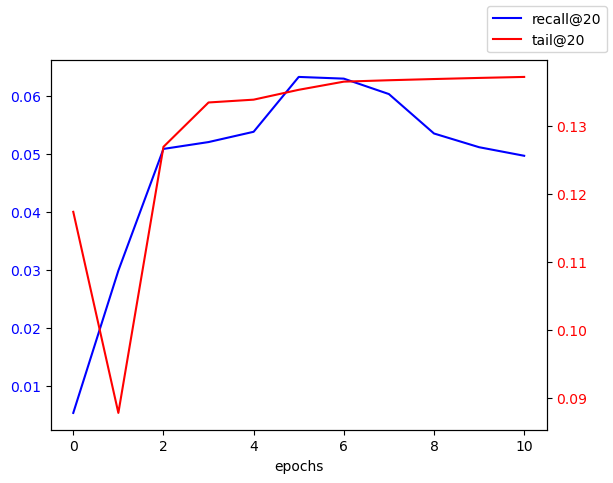

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, len(recall_records))

fig, ax1 = plt.subplots()

ax1.plot(x, recall_records, 'b', label=f'recall@{K}')
ax1.set_xlabel('epochs')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x, tail_records, 'r-', label=f'tail@{K}')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend()

plt.show()


In [16]:
torch.save({
    "state_dict": model.cpu().state_dict(),
    "num_items": num_items,
    "embedding_dim":embedding_dim,
    "hidden_dim": hidden_dim
}, "../parameters/session.pth")